In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import lifelines
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Survival Analysis - Cox PH Assumptions

This notebook contains the code for checking the linearity and proportionality assumptions of Cox PH.

+ Kaplan-Meier Estimations of survival curves are plotted.

+ Cox PH coefficients are printed. The performance (Time Dependent C-Index and Integrated Brier Score) on the whole data set is printed.

+ The test for proportionality test is done in R script 3A_CoxPHAssumptions.R.

+ The linearity test is obtained by the R script 3A_CoxPHAssumptions.R and visualized here.








In [3]:
data = pd.read_pickle("ultimate_data/surv_data_season_fin.pkl")
info = pd.read_pickle("ultimate_data/surv_data_info_season_fin.pkl")


In [4]:
data.shape, info.shape

((443832, 33), (443832, 7))

In [14]:
#data.to_csv("all_cities_buy_surv.csv")

In [15]:
data.head()

,balcony_available_True,investment_rent_active_True,parking_available_True,object_type_FARMHOUSE,object_type_HOUSE_UNKNOWN,object_type_LOFT,object_type_MAISONETTE,object_type_MANSION,object_type_MULTI_FAMILY_HOUSE,object_type_ONE_TWO_FAMILY_HOUSE,object_type_PENTHOUSE,object_type_REGULAR_APARTMENT,object_type_SEMI_DETACHED_HOUSE,object_type_SPECIAL_BUILDING,object_type_TERRACED_HOUSE,season_Spring,season_Summer,season_Winter,address_lat,address_lng,construction_yearfinished,structure_area_living,structure_rooms_living,zip_population_density,object_type_ordinal,zip_market_size,city_distance,time_online,expose_price_sqm,weeks_on_market,status,expected_price_sqm,DOP
376162,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,49.338699,8.648010,2018.0,118.550003,4.0,986.217957,7.0,302.0,0.004658,0.426829,4327.288086,38.0,0.0,3837.040832,1.127767
653342,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,48.024700,10.773090,2020.0,148.460007,5.5,331.082214,1.0,258.0,0.033864,0.731707,4063.047363,19.0,0.0,3826.424280,1.061839
199588,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,49.342388,8.202571,2018.0,113.239998,3.0,255.625641,0.0,300.0,0.055346,0.024390,3266.513672,3.0,1.0,3071.672498,1.063432
914654,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,53.168671,8.691440,1993.0,62.000000,2.0,2874.420654,0.0,244.0,0.119853,0.500000,1532.258057,4.0,1.0,1827.639969,0.838381
660655,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,52.198650,13.585670,1996.0,59.000000,2.0,87.207924,0.0,380.0,0.061685,0.658537,1500.000000,9.0,0.0,1395.668528,1.074754


In [16]:
data.columns

Index(['balcony_available_True', 'investment_rent_active_True', 'parking_available_True', 'object_type_FARMHOUSE', 'object_type_HOUSE_UNKNOWN', 'object_type_LOFT', 'object_type_MAISONETTE', 'object_type_MANSION', 'object_type_MULTI_FAMILY_HOUSE', 'object_type_ONE_TWO_FAMILY_HOUSE', 'object_type_PENTHOUSE', 'object_type_REGULAR_APARTMENT', 'object_type_SEMI_DETACHED_HOUSE', 'object_type_SPECIAL_BUILDING', 'object_type_TERRACED_HOUSE', 'season_Spring', 'season_Summer', 'season_Winter', 'address_lat', 'address_lng', 'construction_yearfinished', 'structure_area_living', 'structure_rooms_living', 'zip_population_density', 'object_type_ordinal', 'zip_market_size', 'city_distance', 'time_online', 'expose_price_sqm', 'weeks_on_market', 'status', 'expected_price_sqm', 'DOP'], dtype='object')

In [5]:
exclude_list = ['object_type_BUNGALOW', 'object_type_FARMHOUSE', 
                'object_type_HOUSE_UNKNOWN', 'object_type_LOFT', 
                'object_type_MAISONETTE', 'object_type_MANSION',
                'object_type_MULTI_FAMILY_HOUSE', 'object_type_ONE_TWO_FAMILY_HOUSE',
                'object_type_PENTHOUSE', 'object_type_REGULAR_APARTMENT',
                'object_type_SEMI_DETACHED_HOUSE', 'object_type_SPECIAL_BUILDING', 
                'object_type_TERRACED_HOUSE','expose_price_sqm']




In [6]:
cols = [c for c in data.columns.to_list() if c not in exclude_list ]

In [7]:
cols

['balcony_available_True',
 'investment_rent_active_True',
 'parking_available_True',
 'season_Spring',
 'season_Summer',
 'season_Winter',
 'address_lat',
 'address_lng',
 'construction_yearfinished',
 'structure_area_living',
 'structure_rooms_living',
 'zip_population_density',
 'object_type_ordinal',
 'zip_market_size',
 'city_distance',
 'time_online',
 'weeks_on_market',
 'status',
 'expected_price_sqm',
 'DOP']

# Kaplan-Meier Estimations

In [10]:
def plot_multi_kmf(data, column, ax):
    from lifelines import KaplanMeierFitter
    kmf = KaplanMeierFitter()
    T = data["weeks_on_market"]
    E = data["status"]
    
    if column in ['balcony_available_True','investment_rent_active_True'
                     ,'parking_available_True','season_Spring','season_Summer'
                     ,'season_Winter']:
        condition = (data[column] == 1)
        kmf.fit(T[condition], event_observed=E[condition], label= 'True')
        kmf.plot_survival_function(ax=ax)
        kmf.fit(T[~condition], event_observed=E[~condition], label= 'False')
        kmf.plot_survival_function(ax=ax)
    elif column == "object_type_ordinal":
        condition1 = (data[column] >= 0) & (data[column] < 2)
        condition2 = (data[column] >= 2) & (data[column] < 4)
        condition3 = (data[column] >= 4) &  (data[column] < 8)
        condition4 = (data[column] >= 8) &  (data[column] <= 13)
        kmf.fit(T[condition1], event_observed=E[condition1], label= 'Type Summary 1')
        kmf.plot_survival_function(ax=ax)
        kmf.fit(T[condition2], event_observed=E[condition2], label= 'Type Summary 2')
        kmf.plot_survival_function(ax=ax)
        kmf.fit(T[condition3], event_observed=E[condition3], label= 'Type Summary 3')
        kmf.plot_survival_function(ax=ax)
        kmf.fit(T[condition4], event_observed=E[condition4], label= 'Type Summary 4')
        kmf.plot_survival_function(ax=ax)
    else:
        cuts = pd.qcut(data[column], 4,labels=['Q1','Q2','Q3','Q4'])
        for col,level in zip(['red','orange','green','blue'],['Q1','Q2','Q3','Q4']):
            condition = (cuts == level)
            kmf.fit(T[condition], event_observed=E[condition], label=level)
            kmf.plot_survival_function(ax=ax,color=col)

In [5]:
def plot_multi_kmf(data, column, ax, plot_limit = (0,50)):
    from lifelines import KaplanMeierFitter
    kmf = KaplanMeierFitter()
    T = data["weeks_on_market"]
    E = data["status"]
    
    if column not in ['balcony_available_True','investment_rent_active_True',
                     ,'parking_available_True']:
        cuts = pd.qcut(data[column], 4,labels=['Q1','Q2','Q3','Q4'])
        for col,level in zip(['red','orange','green','blue'],['Q1','Q2','Q3','Q4']):
            condition = (cuts == level)
            kmf.fit(T[condition], event_observed=E[condition], label=level)
            kmf.plot_survival_function(ax=ax,color=col)
        
    else:
        condition = (data[column] == 1)
        kmf.fit(T[condition], event_observed=E[condition], label= 'True')
        kmf.plot_survival_function(ax=ax)
        kmf.fit(T[~condition], event_observed=E[~condition], label= 'False')
        kmf.plot_survival_function(ax=ax)
        

In [20]:
selected_cols = [c for c in cols if c not in ['weeks_on_market','status']]

In [21]:
selected_cols

['balcony_available_True',
 'investment_rent_active_True',
 'parking_available_True',
 'season_Spring',
 'season_Summer',
 'season_Winter',
 'address_lat',
 'address_lng',
 'construction_yearfinished',
 'structure_area_living',
 'structure_rooms_living',
 'zip_population_density',
 'object_type_ordinal',
 'zip_market_size',
 'city_distance',
 'time_online',
 'expected_price_sqm',
 'DOP']

In [13]:
human_readable = ['Balcony Available',
                 'Actively Rented',
                 'Parking Available',
                  'Spring',
                  'Summer',
                  'Winter',
                 'Latitude',
                 'Longitude',
                 'Construction Year',
                 'Living Area',
                 'Number of Rooms',
                 'Population Density (Zip Code)',
                  'Property Type',
                 'Market Size (Zip Code)',
                 'Distance to the City Centroid',
                 'Time of First Advertisement',
                 'Price per square meter',
                 'DOP']

In [14]:
column_dict= dict(zip(selected_cols,human_readable))

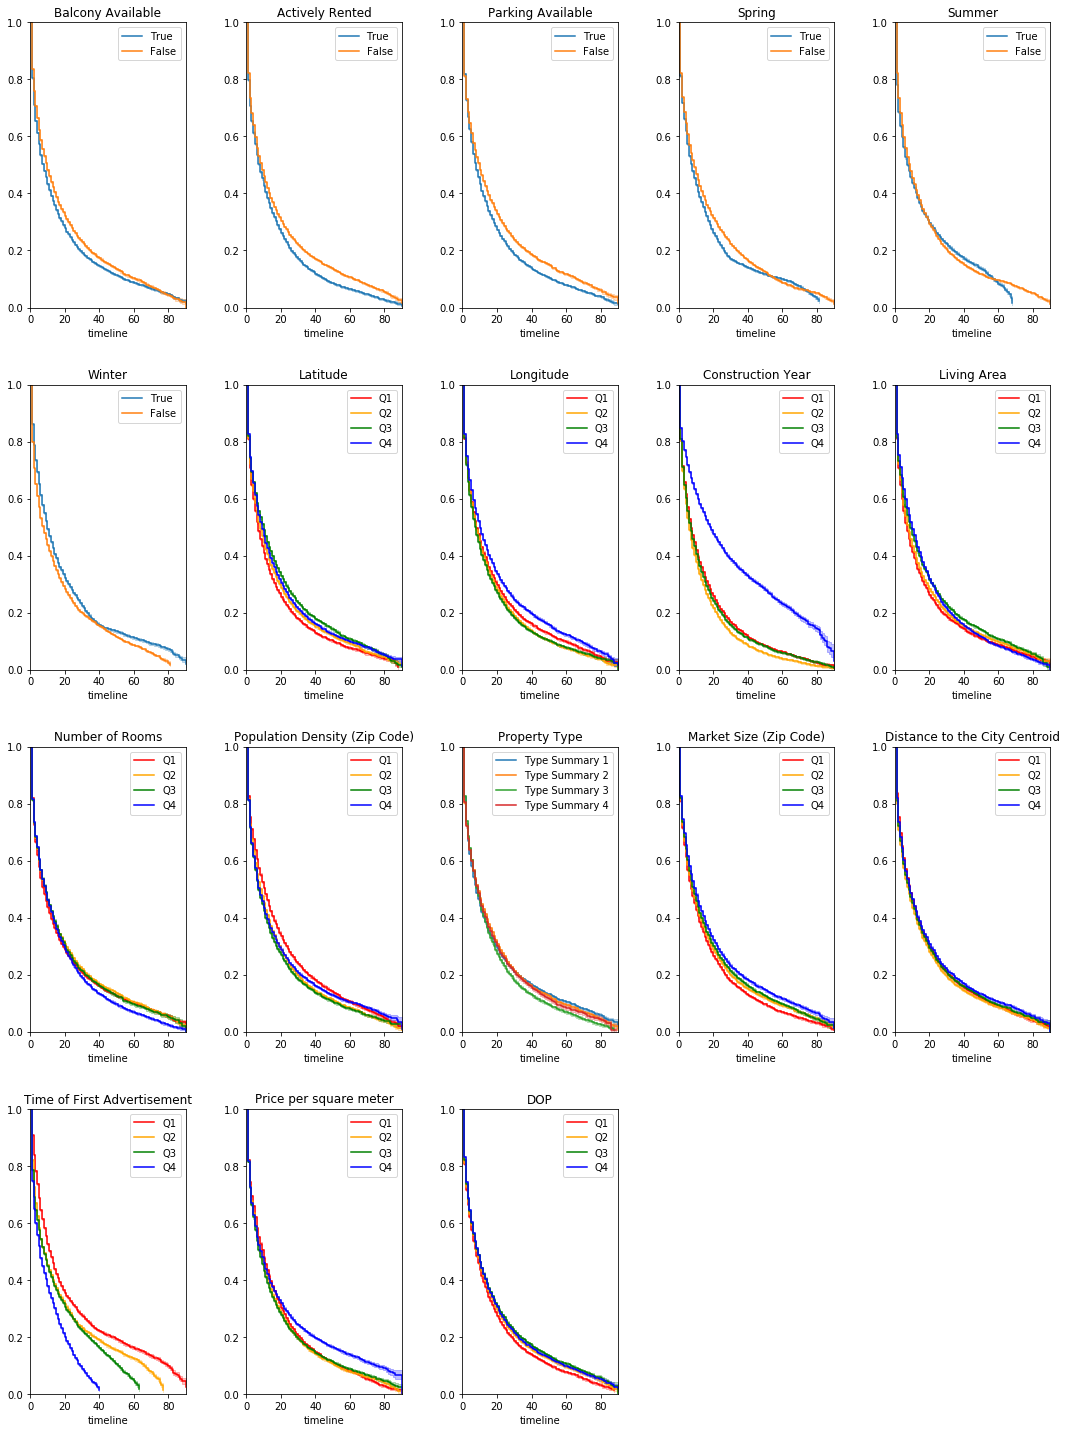

In [52]:
fig, axes = plt.subplots(4, 5, figsize=(15,20), sharex=False, sharey=False)
for i, ax in enumerate(axes.flatten()):
    if i>17:
        ax.remove()
    else:
        plot_multi_kmf(data, selected_cols[i], ax)
        ax.title.set_text(column_dict[selected_cols[i]])
        ax.set_xlim(0,90)
        ax.set_ylim(0,1.0)

fig.tight_layout(h_pad=3, w_pad=2)
#plt.savefig('graphs\km_all.pdf')

In [ ]:
#plt.savefig('km_all.pdf')

# Cox PH Assumptions

In [17]:
data.head()

,balcony_available_True,investment_rent_active_True,parking_available_True,object_type_FARMHOUSE,object_type_HOUSE_UNKNOWN,object_type_LOFT,object_type_MAISONETTE,object_type_MANSION,object_type_MULTI_FAMILY_HOUSE,object_type_ONE_TWO_FAMILY_HOUSE,object_type_PENTHOUSE,object_type_REGULAR_APARTMENT,object_type_SEMI_DETACHED_HOUSE,object_type_SPECIAL_BUILDING,object_type_TERRACED_HOUSE,season_Spring,season_Summer,season_Winter,address_lat,address_lng,construction_yearfinished,structure_area_living,structure_rooms_living,zip_population_density,object_type_ordinal,zip_market_size,city_distance,time_online,expose_price_sqm,weeks_on_market,status,expected_price_sqm,DOP
376162,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,49.338699,8.648010,2018.0,118.550003,4.0,986.217957,7.0,302.0,0.004658,0.426829,4327.288086,38.0,0.0,3837.040832,1.127767
653342,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,48.024700,10.773090,2020.0,148.460007,5.5,331.082214,1.0,258.0,0.033864,0.731707,4063.047363,19.0,0.0,3826.424280,1.061839
199588,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,49.342388,8.202571,2018.0,113.239998,3.0,255.625641,0.0,300.0,0.055346,0.024390,3266.513672,3.0,1.0,3071.672498,1.063432
914654,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,53.168671,8.691440,1993.0,62.000000,2.0,2874.420654,0.0,244.0,0.119853,0.500000,1532.258057,4.0,1.0,1827.639969,0.838381
660655,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,52.198650,13.585670,1996.0,59.000000,2.0,87.207924,0.0,380.0,0.061685,0.658537,1500.000000,9.0,0.0,1395.668528,1.074754


In [8]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()

cph.fit(data.drop(["object_type_ordinal","expose_price_sqm"],axis=1), 'weeks_on_market', 'status')



<lifelines.CoxPHFitter: fitted with 443832 total observations, 134894 right-censored observations>

In [9]:
cph.print_summary()

In [25]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
balcony_available_True,0.051645,1.053002,4.153393e-03,0.043505,0.059786,1.044465,1.061609,12.434441,1.699256e-35,115.502580
investment_rent_active_True,0.011766,1.011836,4.724640e-03,0.002506,0.021026,1.002509,1.021249,2.490411,1.275953e-02,6.292281
parking_available_True,0.141969,1.152541,4.019512e-03,0.134091,0.149847,1.143497,1.161657,35.319971,2.899412e-273,905.350609
object_type_FARMHOUSE,0.016696,1.016836,3.039913e-02,-0.042886,0.076277,0.958021,1.079261,0.549213,5.828589e-01,0.778781
object_type_HOUSE_UNKNOWN,0.128390,1.136997,1.398642e-02,0.100977,0.155803,1.106252,1.168596,9.179643,4.325220e-20,64.325788
object_type_LOFT,-0.031880,0.968623,5.995952e-02,-0.149399,0.085638,0.861226,1.089412,-0.531695,5.949375e-01,0.749190
object_type_MAISONETTE,0.003021,1.003025,1.734411e-02,-0.030973,0.037014,0.969501,1.037708,0.174153,8.617452e-01,0.214667
object_type_MANSION,0.174295,1.190406,2.308044e-02,0.129058,0.219531,1.137756,1.245493,7.551612,4.299042e-14,44.402978
object_type_MULTI_FAMILY_HOUSE,0.080347,1.083663,1.526259e-02,0.050433,0.110261,1.051727,1.116570,5.264327,1.407037e-07,22.760836
object_type_ONE_TWO_FAMILY_HOUSE,0.021549,1.021783,1.261226e-02,-0.003170,0.046269,0.996835,1.047356,1.708595,8.752599e-02,3.514145


# Cox PH performance when trained on the whole data set


Note that the comparison with DeepHit is done on a cross-validation setting



In [4]:
surv = cph.predict_survival_function(data)

In [5]:
get_target = lambda df: (df['weeks_on_market'].values.astype("float32"), 
                         df['status'].values.astype("float32"))

durations, events = get_target(data)
time_grid = np.linspace(durations.min(), durations.max(), 100)

In [6]:
from pycox.evaluation import EvalSurv
ev = EvalSurv(surv, durations, events, censor_surv='km')


In [7]:
c_index = ev.concordance_td('antolini')
i_brier = ev.integrated_brier_score(time_grid) 

In [8]:
c_index, i_brier

(0.5777427260597765, 0.08991630339351904)

# Linearity Test

In [53]:
import feather
import numpy as np
import pandas as pd

In [54]:
cox_lin = feather.read_dataframe("cox_linearity_new.feather")

In [55]:
cox_lin.iloc[:,0].min()

0.09483790704468713

In [56]:
cox_lin.head()

,DOP_explanatory,DOP_martingale_resid,DOP_lowess_x,DOP_lowess_y,expected_price_sqm_explanatory,expected_price_sqm_martingale_resid,expected_price_sqm_lowess_x,expected_price_sqm_lowess_y,address_lat_explanatory,address_lat_martingale_resid,address_lat_lowess_x,address_lat_lowess_y,address_lng_explanatory,address_lng_martingale_resid,address_lng_lowess_x,address_lng_lowess_y,structure_rooms_living_explanatory,structure_rooms_living_martingale_resid,structure_rooms_living_lowess_x,structure_rooms_living_lowess_y,structure_area_living_explanatory,structure_area_living_martingale_resid,structure_area_living_lowess_x,structure_area_living_lowess_y,construction_yearfinished_explanatory,construction_yearfinished_martingale_resid,construction_yearfinished_lowess_x,construction_yearfinished_lowess_y,zip_market_size_explanatory,zip_market_size_martingale_resid,zip_market_size_lowess_x,zip_market_size_lowess_y,city_distance_explanatory,city_distance_martingale_resid,city_distance_lowess_x,city_distance_lowess_y,time_online_explanatory,time_online_martingale_resid,time_online_lowess_x,time_online_lowess_y,zip_population_density_explanatory,zip_population_density_martingale_resid,zip_population_density_lowess_x,zip_population_density_lowess_y
0,0.956045,0.741949,0.094838,0.208492,1888.261040,0.741949,541.968605,-0.141661,49.317703,0.741949,47.46415,0.101927,12.088212,0.741949,5.87777,-0.003459,6.0,0.741949,1.0,0.065622,152.0,0.741949,20.02,0.107950,2018.0000,0.741949,1850.0,-0.197196,419.0,0.741949,1.0,0.110148,0.004880,0.741949,0.0,-0.076683,0.123288,0.741949,0.0,-0.241561,211.31815,0.741949,8.208832,-0.124385
1,0.922065,0.384237,0.113892,0.203106,2347.990256,0.384237,548.546833,-0.140765,48.317490,0.384237,47.47340,0.101675,8.917600,0.384237,5.88226,-0.003431,4.0,0.384237,1.0,0.065622,160.0,0.384237,20.02,0.107950,1998.2609,0.384237,1850.0,-0.197196,267.0,0.384237,2.0,0.109831,0.015689,0.384237,0.0,-0.076683,0.301370,0.384237,0.0,-0.241561,278.74026,0.384237,14.281998,-0.122727
2,1.021936,-1.027049,0.114040,0.203064,1782.114908,-1.027049,548.983002,-0.140705,52.439260,-1.027049,47.47349,0.101672,9.194140,-1.027049,5.88966,-0.003386,6.0,-1.027049,1.0,0.065622,198.0,-1.027049,20.02,0.107950,2018.0000,-1.027049,1850.0,-0.197196,245.0,-1.027049,2.0,0.109831,0.026942,-1.027049,0.0,-0.076683,0.534247,-1.027049,0.0,-0.241561,102.19135,-1.027049,14.281998,-0.122727
3,1.227157,0.282657,0.138778,0.196071,2839.773307,0.282657,549.858769,-0.140586,53.045520,0.282657,47.47349,0.101672,8.863990,0.282657,5.89302,-0.003365,5.0,0.282657,1.0,0.065622,165.0,0.282657,20.03,0.107938,2014.0000,0.282657,1850.0,-0.197196,229.0,0.282657,2.0,0.109831,0.092256,0.282657,0.0,-0.076683,0.068493,0.282657,0.0,-0.241561,1766.00850,0.282657,14.281998,-0.122727
4,0.827999,0.902150,0.140755,0.195513,1130.005228,0.902150,550.636810,-0.140480,50.387650,0.902150,47.47349,0.101672,6.555360,0.902150,5.89631,-0.003345,8.0,0.902150,1.0,0.065622,202.0,0.902150,20.04,0.107926,1974.0000,0.902150,1850.0,-0.197196,243.0,0.902150,2.0,0.109831,0.045141,0.902150,0.0,-0.076683,0.630137,0.902150,0.0,-0.241561,44.25788,0.902150,14.281998,-0.122727


In [57]:
col_list = ["DOP","Expected Price per Square Meter",
           "Latitude","Longitude",
            
           "Number of Rooms",
            "Living Area",
           
            "Construction Year",
            
            "Market Size (Zip Code)",
           
            "Distance to the City Centroid",
            
           "Time Since First Advertisement",
           
           "Population Density (Zip Code)"]

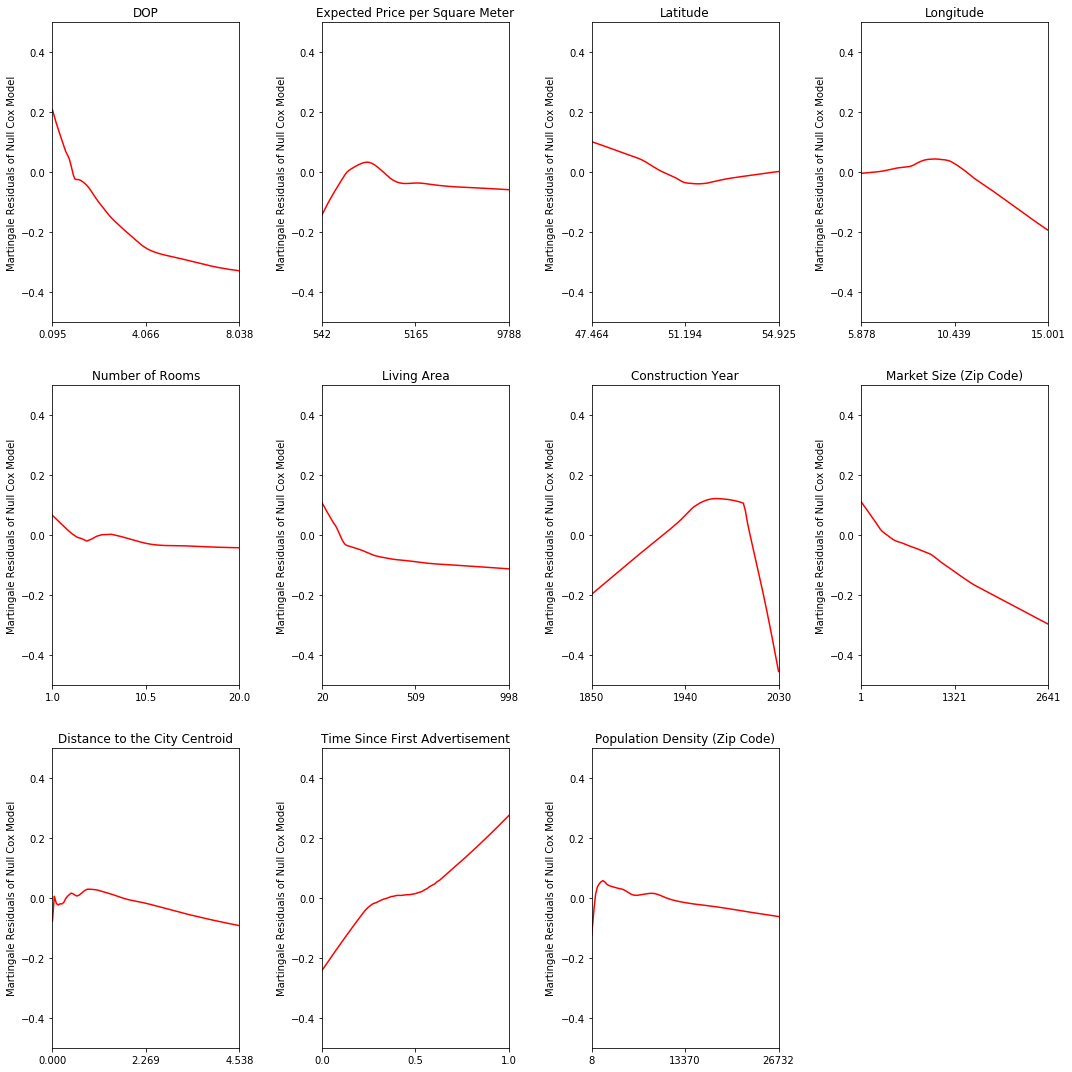

In [61]:
fig, axes = plt.subplots(3, 4, figsize=(15,15), sharex=False, sharey=False)
for i, ax in enumerate(axes.flatten()):
    if i ==11:
        ax.remove()
    else:
        ax.plot(cox_lin.iloc[:,4*i+2],cox_lin.iloc[:,4*i+3], color = "red")
        ax.set_title(col_list[i])
        ax.set_ylabel("Martingale Residuals of Null Cox Model")
        ax.set_ylim(-0.5,0.5)
        x_min = min(cox_lin.iloc[:,4*i].min(),cox_lin.iloc[:,4*i+2].min() )
        x_max = max(cox_lin.iloc[:,4*i].max(),cox_lin.iloc[:,4*i+2].max() )
        ax.set_xlim(x_min,x_max)
        ax.set_xticks((x_min,np.median([x_min,x_max]) ,x_max))

fig.tight_layout(h_pad=3, w_pad=2)
plt.savefig('graphs/cox_linearity.pdf')